In [1]:
# Allows us to import files from the base folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

# Imports
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit, value_and_grad
import optax

import numpy as np

from pymatching import Matching

import matplotlib.pyplot as plt

from packages.quantum_error_correction import *
from packages.neural_network import *

from icecream import ic  # For debugging

key = jax.random.key(42)

# Initialize the QEC code that will be used

Rate of non-trivial cases: 99.99%


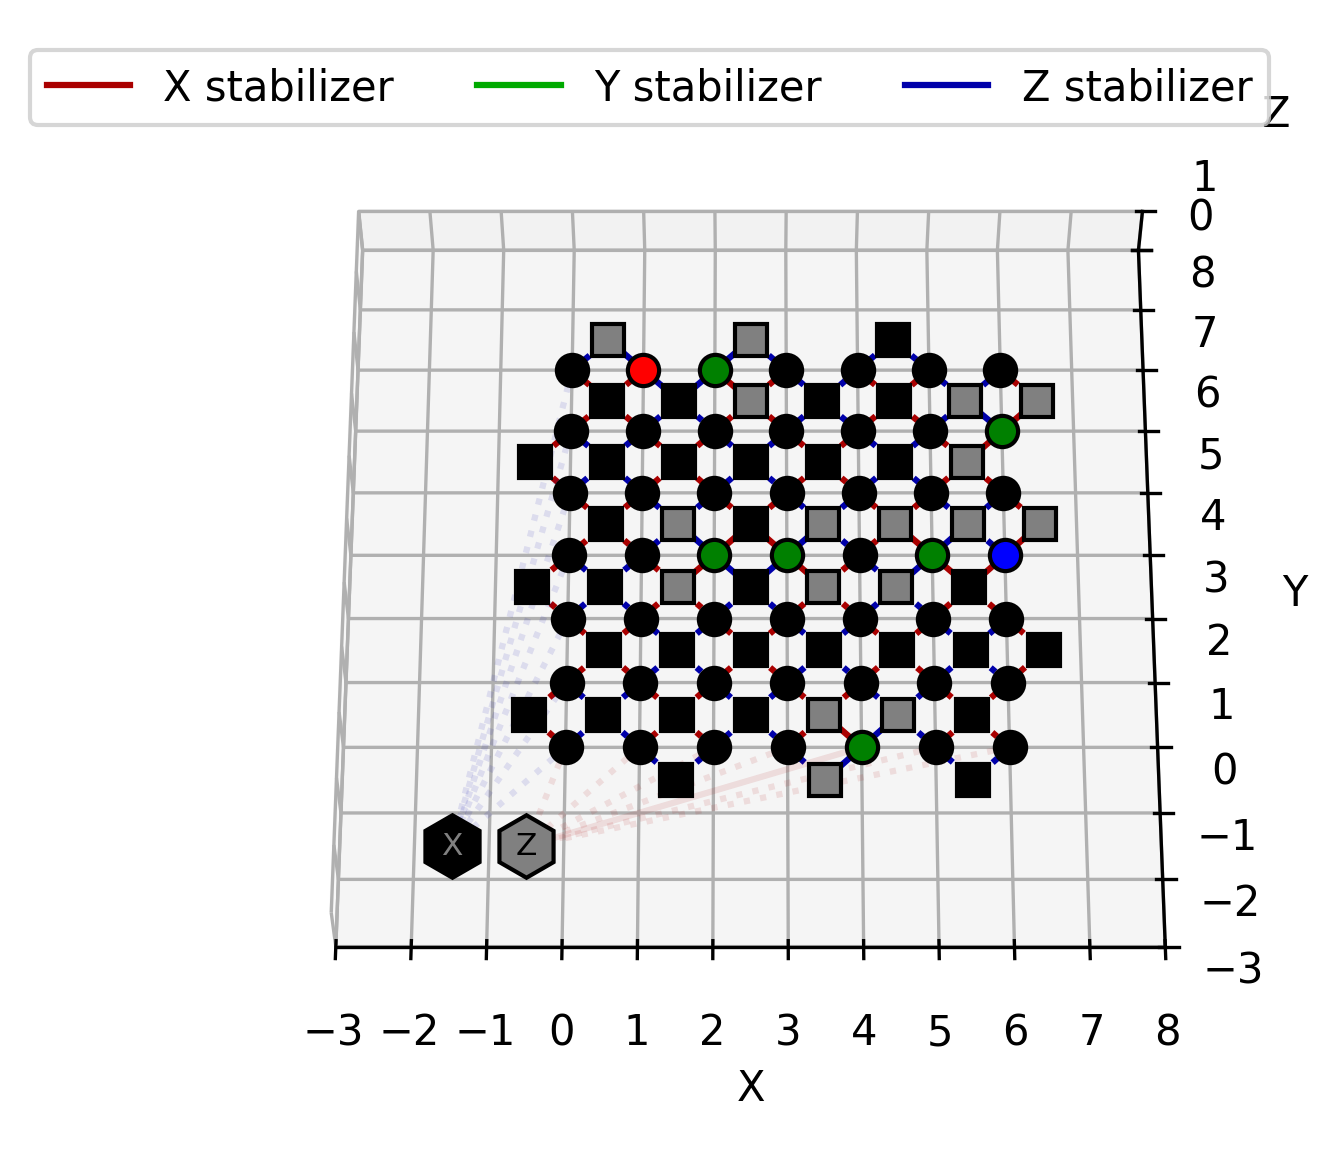

In [15]:
error_prob = [.01, .15, .01]
code_distance = 7

subkey, key = jax.random.split(key)
errors = jax_create_error_batch(*error_prob, size=code_distance**2, batch_size=1, key=subkey)

# error_prob = [.001, .15, .001]
# errors = jnp.array([[
#     0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0
# ]])

qec = QEC(surface_code_data_wls(d=code_distance))
info = {}
info['Mx'], info['My'], info['Mz'] = qec.transformation_matrix()
# Split into matrix for syndrome qubits in logical detectors
info['Sx'], info['Lx'] = info['Mx'][:-2], info['Mx'][-2:]
info['Sy'], info['Ly'] = info['My'][:-2], info['My'][-2:]
info['Sz'], info['Lz'] = info['Mz'][:-2], info['Mz'][-2:]
nsq, ndq = info['Sx'].shape
qec.show(errors=errors[0]);

print(f'Rate of non-trivial cases: {1-(1-sum(error_prob))**ndq:.2%}')

syndromes = jax_get_syndromes_batch(info['Sx'], info['Sy'], info['Sz'], errors)
code_logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], errors)

In [16]:
Sa = jnp.where(info['Sx'].sum(axis=1) > 0)
Sb = jnp.where(info['Sz'].sum(axis=1) > 0)

Ha = info['Sx'][Sa]
Hb = info['Sz'][Sb]

[-0.         2.4274533  1.         2.4274533]


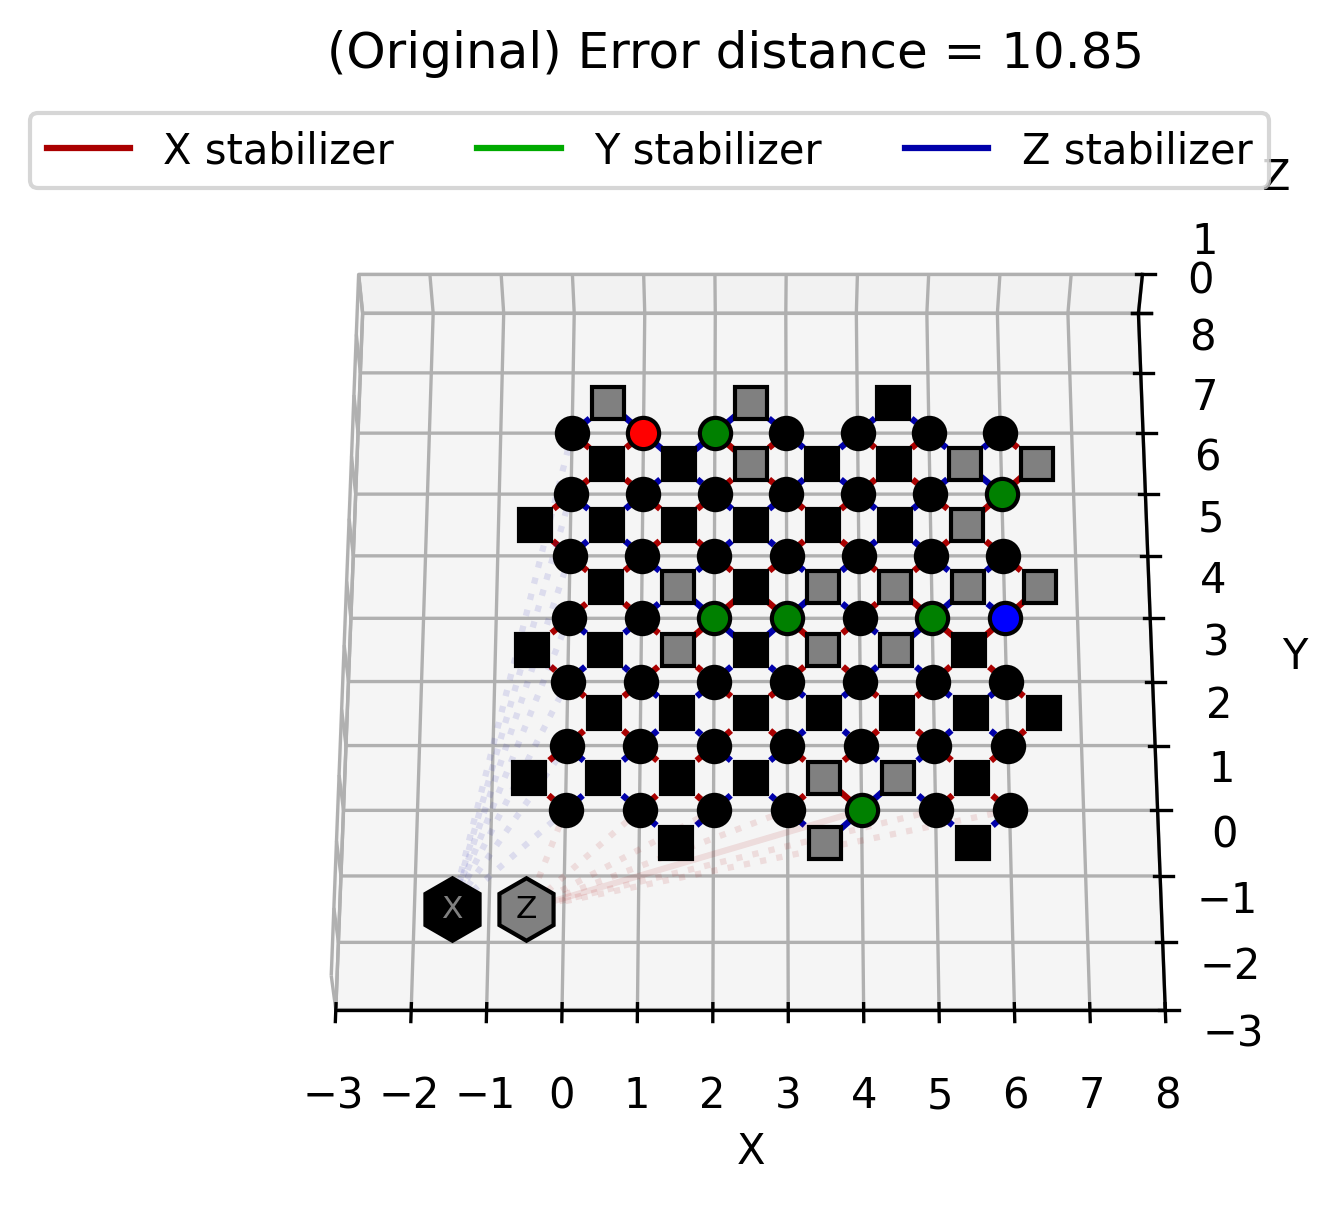

In [17]:
Px = jnp.ones(shape=ndq)*error_prob[0]
Py = jnp.ones(shape=ndq)*error_prob[1]
Pz = jnp.ones(shape=ndq)*error_prob[2]
syndrome = syndromes[0]

Ra = jnp.zeros(shape=(ndq))
Rb = jnp.zeros(shape=(ndq))

cost = jnp.log(jnp.array([1, *error_prob])) / jnp.log(max(error_prob))
print(cost)

qec.show(errors=errors[0], title=f"(Original) Error distance = {cost[errors[0]].sum():.2f}");

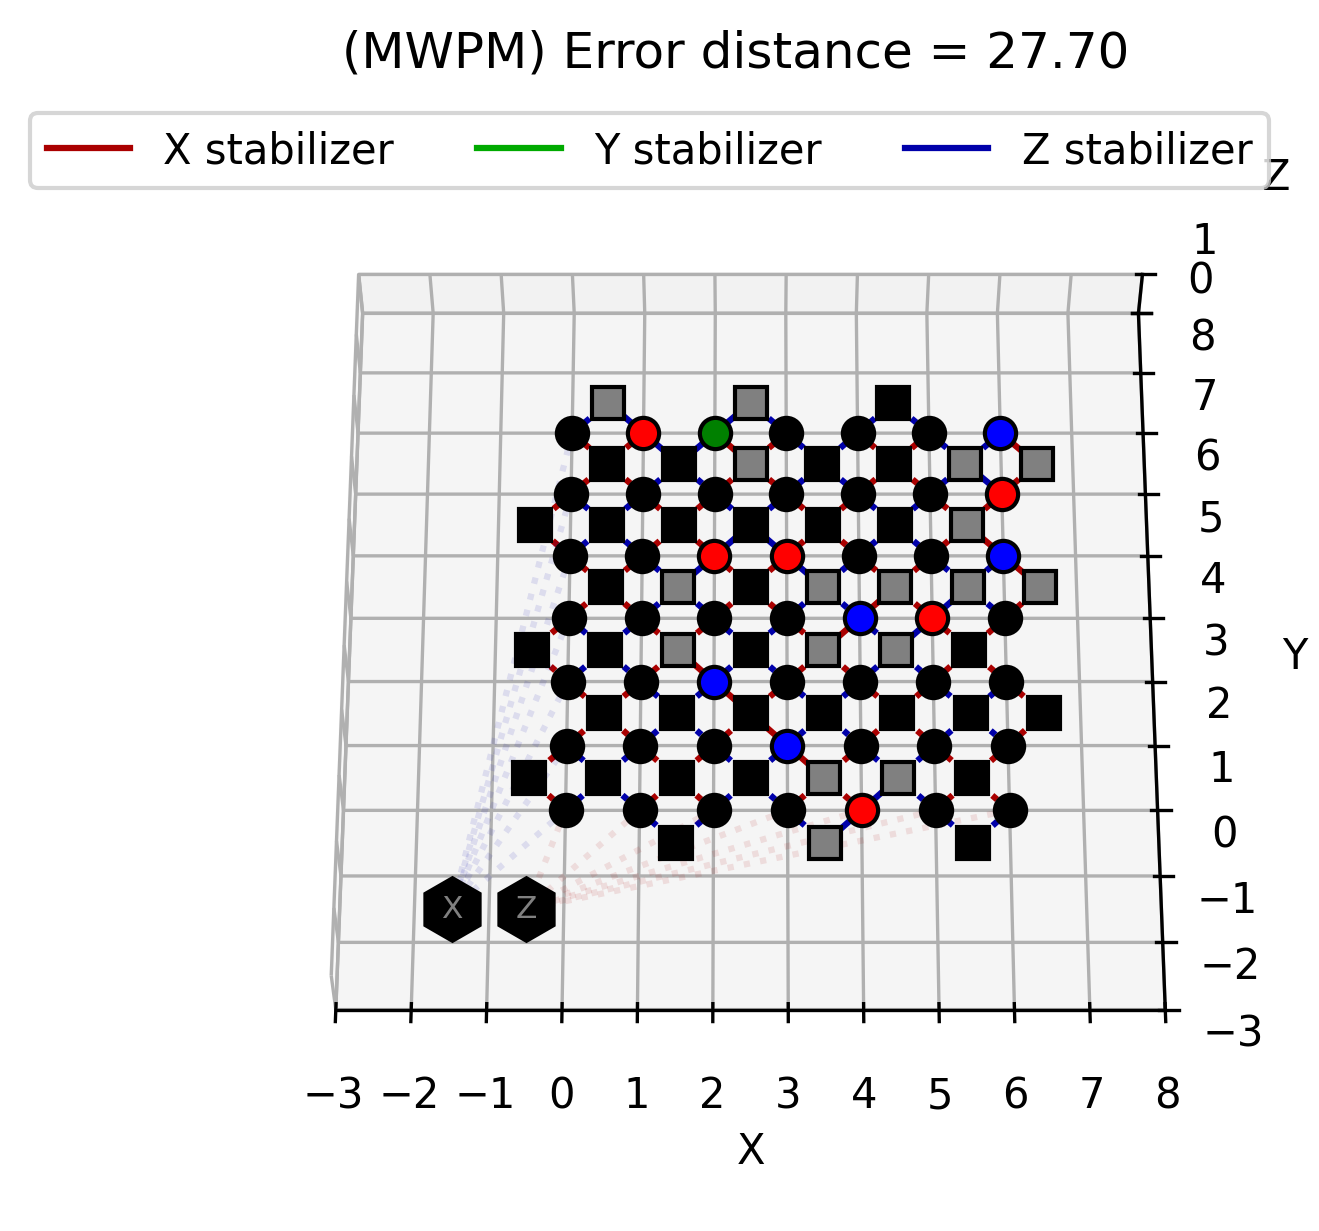

In [18]:
MWPM = Matching(jnp.append(info['Sx'], info['Sz'], axis=1))
decoding = MWPM.decode_batch(syndromes)
recovery = jnp.where(decoding[:,:ndq]==1, jnp.where(decoding[:,ndq:]==1, 2, 1), jnp.where(decoding[:,ndq:]==1, 3, 0))
qec.show(errors=recovery[0], title=f"(MWPM) Error distance = {cost[recovery[0]].sum():.2f}");

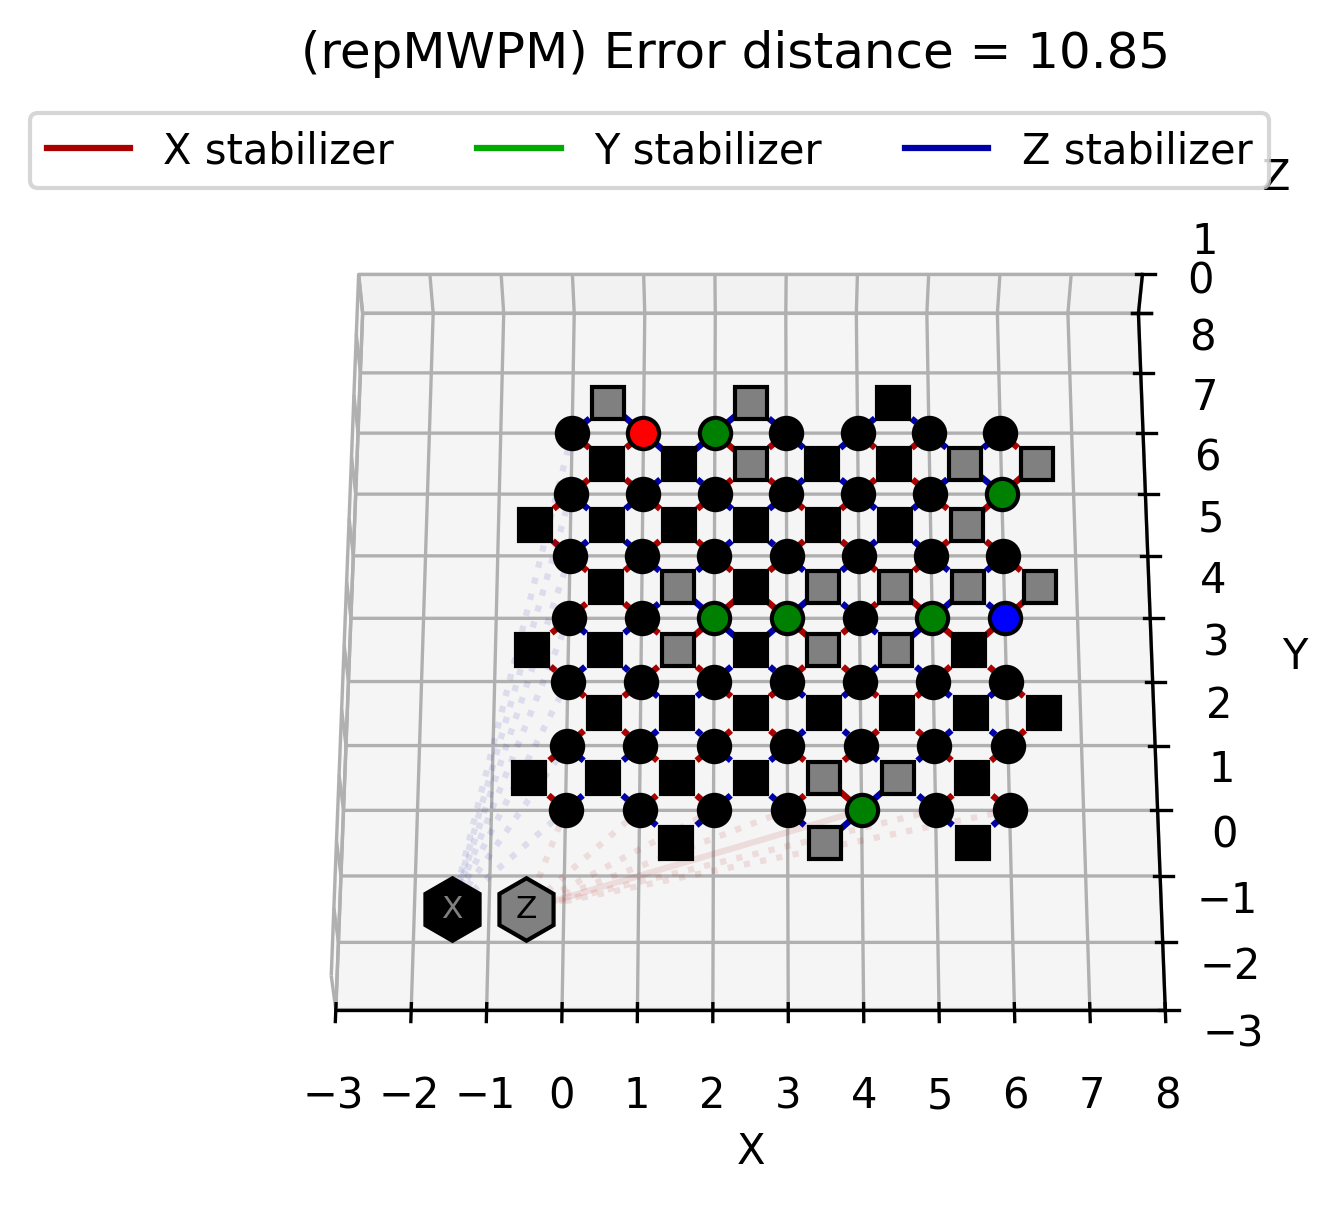

In [24]:
Ra = jnp.zeros(shape=(ndq))
Rb = jnp.zeros(shape=(ndq))

show_steps = False
graph = 'X'
for _ in range(10):
    if graph == 'X':
        W = -jnp.log(jnp.where(Rb == 1, Py/Pz, Px))
        Ma = Matching(Ha, weights=W)
        Ra_ = Ma.decode(syndrome[Sa])
        if jnp.array_equal(Ra, Ra_):
            break
        Ra = Ra_
    elif graph == 'Z':
        W = -jnp.log(jnp.where(Ra == 1, Py/Px, Pz))
        Mb = Matching(Hb, weights=W)
        Rb_ = Mb.decode(syndrome[Sb])
        if jnp.array_equal(Rb, Rb_):
            break
        Rb = Rb_
    else:
        raise NameError(graph)

    if show_steps:
        recovery = jnp.where(
            Ra==1, 
            jnp.where(Rb==1, 2, 1), 
            jnp.where(Rb==1, 3, 0)
        )
        qec.show(errors=recovery, title=f"({graph}-graph) Error distance = {cost[recovery].sum():.2f}");
    graph = 'X' if graph == 'Z' else 'Z'

recovery = jnp.where(
    Ra==1, 
    jnp.where(Rb==1, 2, 1), 
    jnp.where(Rb==1, 3, 0)
)
qec.show(errors=recovery, title=f"(repMWPM) Error distance = {cost[recovery].sum():.2f}");